In [2]:
%run notebook.config.ipy

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
set database db: ../csvdb
set database anndb: /gfs/mirror/annotations/mm10_ensembl78/csvdb
set database ipydb: csvdb


In [3]:
count_table_filtered = DB.fetch_DataFrame('''select * from count_table_filtered''', ipydb)

**Brennecke and Heiseler noise analysis**
http://www.nature.com/nmeth/journal/v10/n11/extref/nmeth.2645-S2.pdf

In [4]:
%%R
#additional libraries
library(matrixStats)
library(DESeq2)
library(genefilter)
library(statmod)

matrixStats v0.14.0 (2015-02-13) successfully loaded. See ?matrixStats for help.
Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following object is masked from ‘package:stats’:

    xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, as.vector, cbind, colnames,
    do.call, duplicated, eval, evalq, Filter, Find, get, intersect,
    is.unsorted, lapply, Map, mapply, match, mget, order, paste, pmax,
    pmax.int, pmin, pmin.int, Position, rank, rbind, Reduce, rep.int,
    rownames, sapply, setdiff, sort, table, tapply, union, unique,
    unlist, unsplit


Attaching package

*(1) Calcuation of size factors*

In [5]:
%%R -i count_table_filtered
require(DESeq2)
#print(head(count_table))

dataMouse <- count_table_filtered
rownames(dataMouse) <- dataMouse$gene_id
dataMouse$gene_id <- NULL


geneTypes <- factor( c( ENSM="ENSM", ERCC="ERCC" )[
  substr( rownames(dataMouse), 1, 4 ) ] )

#2. calculate normalisation for counts
countsMmus <- dataMouse[ which( geneTypes=="ENSM" ), ]
countsERCC <- dataMouse[ which( geneTypes=="ERCC" ), ]
#lengthsMmus <- dataMouse[ which( geneTypes=="ENSM" ), 1 ]
#lengthsERCC <- dataMouse[ which( geneTypes=="ERCC" ), 1 ]

sfMmus <- estimateSizeFactorsForMatrix( countsMmus )
sfERCC <- estimateSizeFactorsForMatrix( countsERCC )

In [6]:
%%R
#print(tail(rownames(dataMouse)))
rbind(sfERCC, sfMmus)

           index L16755_7.0 L16755_7.1 L16755_7.18 L16755_7.19 L16755_7.20
sfERCC  7.868203   3.525186  0.2046605   1.0953678    1.560341    1.275646
sfMmus 28.006614   2.050915  0.3304312   0.8929182    1.352599    1.054284
       L16755_7.21 L16755_7.22 L16755_7.23 L16755_7.24 L16755_7.25 L16755_7.27
sfERCC    0.685167   0.5303745   0.4645497   0.5853286   0.9938234    1.920449
sfMmus    1.134299   0.7402917   0.7344593   0.3329709   0.7605891    1.641562
       L16755_7.29 L16755_7.3 L16755_7.31 L16755_7.38 L16755_7.39 L16755_7.40
sfERCC   0.8161879  0.7111247   0.3811787   1.0442720   0.4749271   0.6901217
sfMmus   0.8503657  2.2533891   0.2322374   0.7339907   0.8474557   0.3993788
       L16755_7.41 L16755_7.42 L16755_7.43 L16755_7.45 L16755_7.46 L16755_7.47
sfERCC   0.7670537    1.040755    1.758344    1.184143   0.9418800   0.9962934
sfMmus   0.8550801    1.478338    1.534368    1.710526   0.5721747   0.4898448
       L16755_7.48 L16755_7.49 L16755_7.50 L16755_7.51 L16755_7.52 

*(2) Normalisation of spikes and biological genes*

In [7]:
%%R
#normalise read counts
nCountsERCC <- t( t(countsERCC) / sfERCC )
nCountsMmus <- t( t(countsMmus) / sfMmus )

*(3) Calculation of sample moments*

In [8]:
%%R
meansERCC <- rowMeans( nCountsERCC )
varsERCC <- rowVars( nCountsERCC )
cv2ERCC <- varsERCC / meansERCC^2
meansMmus <- rowMeans( nCountsMmus )
varsMmus <- rowVars( nCountsMmus )
cv2Mmus <- varsMmus / meansMmus^2

*(4) Fit technical noise*

In [9]:
%%R
minMeanForFitA <- unname( quantile( meansERCC[ which( cv2ERCC > 0.1 ) ], 0.999 ) ) #default 0.3, 0.8
useForFitA <- meansERCC <= minMeanForFitA
minMeanForFitA
table( useForFitA )

useForFitA
FALSE  TRUE 
    1    91 


In [10]:
%%R
fitA <- glmgam.fit( cbind( a0 = 1, a1tilde = 1/meansERCC[useForFitA] ),
 cv2ERCC[useForFitA] )

Variance explained by fit

In [11]:
%%R
residualA <- var( log( fitted.values(fitA) ) - log( cv2ERCC[useForFitA] ) )
totalA <- var( log( cv2ERCC[useForFitA] ) )
1 - residualA / totalA

[1] 0.8346067


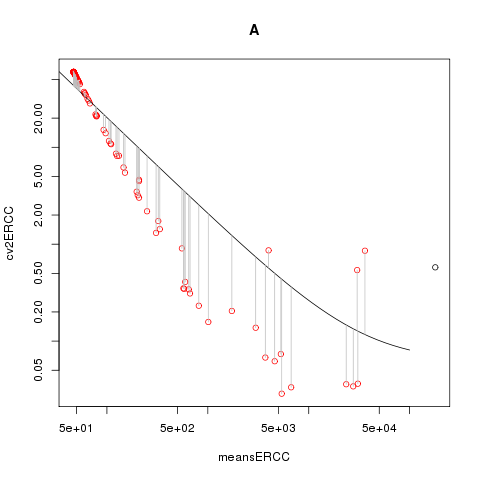

In [12]:
%%R
plot( meansERCC, cv2ERCC, log="xy", col=1+useForFitA, main="A" )
xg <- 10^seq( -3, 5, length.out=100 )
lines( xg, coefficients(fitA)["a0"] + coefficients(fitA)["a1tilde"]/xg )
segments( meansERCC[useForFitA], cv2ERCC[useForFitA],
 meansERCC[useForFitA], fitA$fitted.values, col="gray" )

*(5) Test for high variance*

In [13]:
%%R
minBiolDisp <- .5^2
xi <- mean( 1 / sfERCC )
m <- ncol(countsMmus)
psia1thetaA <- mean( 1 / sfERCC ) +
 ( coefficients(fitA)["a1tilde"] - xi ) * mean( sfERCC / sfMmus )
cv2thA <- coefficients(fitA)["a0"] + minBiolDisp + coefficients(fitA)["a0"] * minBiolDisp

testDenomA <- ( meansMmus * psia1thetaA + meansMmus^2 * cv2thA ) / ( 1 + cv2thA/m )
pA <- 1 - pchisq( varsMmus * (m-1) / testDenomA, m-1 )
padjA <- p.adjust( pA, "BH" )
table( padjA < .1 )



FALSE  TRUE 
21981    38 


*(6) Plot result*

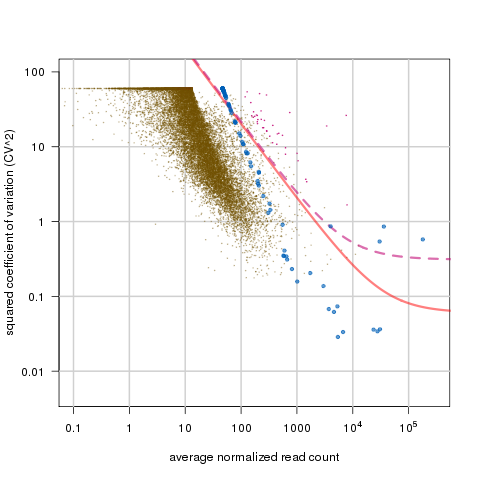

In [14]:
%%R

plot( NULL, xaxt="n", yaxt="n",
 log="xy", xlim = c( 1e-1, 3e5 ), ylim = c( .005, 100 ),
 xlab = "average normalized read count", ylab = "squared coefficient of variation (CV^2)" )
axis( 1, 10^(-1:5), c( "0.1", "1", "10", "100", "1000",
 expression(10^4), expression(10^5) ) )
axis( 2, 10^(-2:2), c( "0.01", "0.1", "1", "10" ,"100"), las=2 )
abline( h=10^(-2:1), v=10^(-1:5), col="#D0D0D0", lwd=2 )
# Plot the plant genes, use a different color if they are highly variable
points( meansMmus, cv2Mmus, pch=20, cex=.2,
 col = ifelse( padjA < .1, "#C0007090", "#70500040" ) )
# Add the technical noise fit, as before
xg <- 10^seq( -2, 6, length.out=1000 )

lines( xg, coefficients(fitA)["a1tilde"] / xg + coefficients(fitA)["a0"], col="#FF000080", lwd=3 )
# Add a curve showing the expectation for the chosen biological CV^2 thershold
lines( xg, psia1thetaA/xg + coefficients(fitA)["a0"] + minBiolDisp,
 lty="dashed", col="#C0007090", lwd=3 )
# Add the normalised ERCC points
points( meansERCC, cv2ERCC, pch=20, cex=1, col="#0060B8A0" )